In [166]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from uncertainties import ufloat
from uncertainties import umath as unp
import scipy.signal

In [3]:
def get_files(folder):
    files = []
    for file in os.listdir(folder):
        if file.endswith(".txt"): 
            files.append(file)
    return files

In [248]:
def n(theta):
    # sqrt((2/sqrt(3)*sin theta + 1/2)^2+3/4)
    theta = theta * 2*np.pi/360
    return unp.sqrt((2/np.sqrt(3)*unp.sin(theta)+0.5)**2+3/4)

def wavelength(theta):
    A = ufloat(13900e-18, 50e-18)
    B = ufloat(1.689, 0.0005)
    return unp.sqrt(A/(n(theta) - B))

def T(V, I):
    T0 = 273.15 + ufloat(20, 0.5)
    alpha0 = ufloat(4.5e-3, 0.05e-3)
    R0 = ufloat(1.1, 0.05)
    return T0 + (V/(I*R0) -1)/alpha0

In [ ]:
DATAPATH = "data"

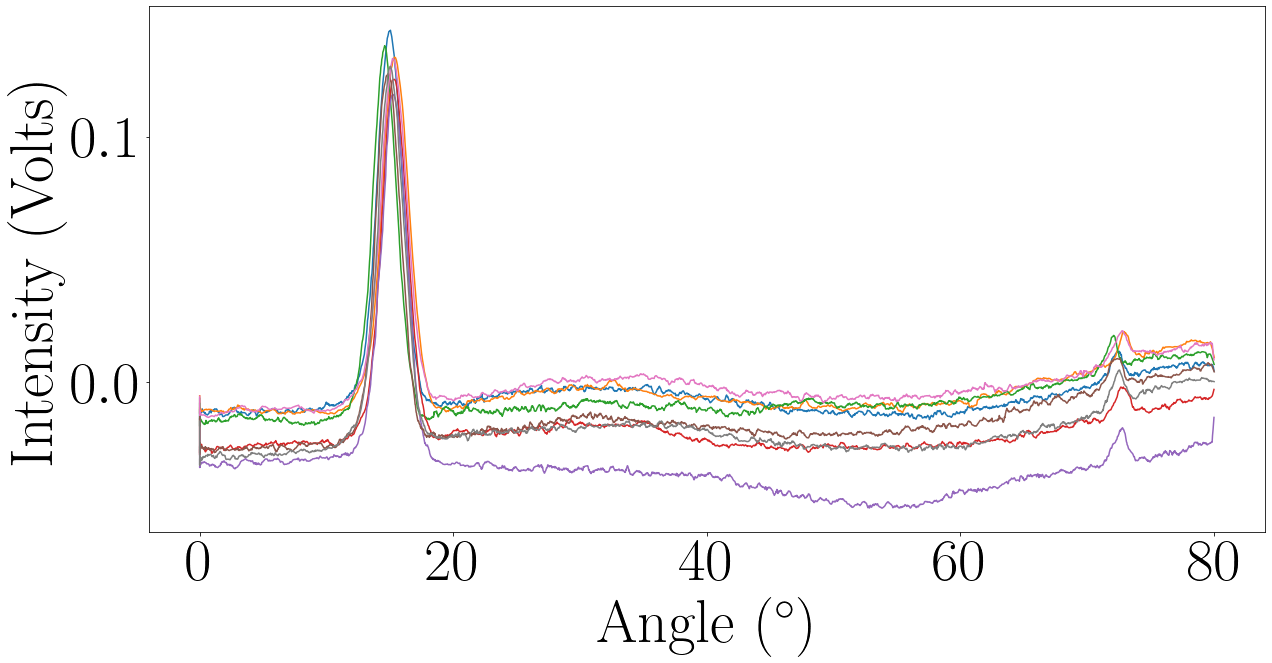

In [262]:
file_list = get_files(DATAPATH)
theta_blip_list = []

plt.figure(figsize=(20,10))
for file_name in file_list[:-1]:
    file_path = os.path.join(DATAPATH, file_name)

    parameters = file_name.split("-")
    angle_range = float(parameters[0])

    with open(file_path) as f:
        data = np.loadtxt(file_path, skiprows=2) # skip first two rows

        theta_list = data[:,0]
        I_list = data[:,1]
        I_list_smooth = np.convolve(I_list, np.ones((10,))/10, mode='same') # smoothing

        # Get the blip angle
        if angle_range == 80:

            # Plot settings
            plt.rcParams.update({'font.size': 60,   "text.usetex": True, "font.family": "Helvetica"})
            plt.xlabel("Angle ($^\circ$)")
            plt.ylabel("Intensity (Volts)")

            # Plot angle vs intensity
            plt.plot(theta_list, I_list_smooth, label=file_name)

            # Get index of theta=70 and theta=75 (blip occurs somewhere in between)
            theta_70_index = np.argmin(np.abs(theta_list - 70))
            theta_75_index = np.argmin(np.abs(theta_list - 75))

            # Find index of blip
            blip_index = np.argmax(I_list_smooth[theta_70_index:theta_75_index]) + theta_70_index

            # Get blip angle
            theta_blip = theta_list[blip_index]
            theta_blip_list.append(theta_blip)

plt.gcf().subplots_adjust(bottom=0.15)


(0.0023851416319330826, 0.00020321209328365565)

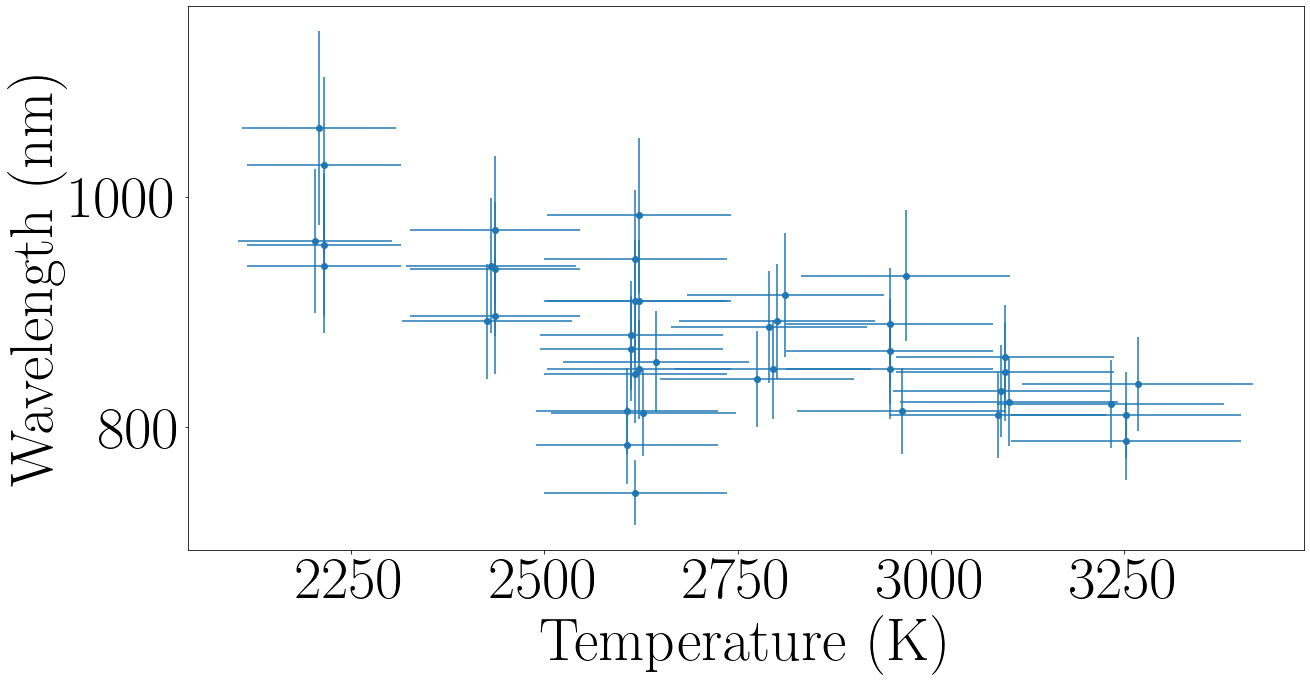

In [269]:
file_list = get_files(DATAPATH)

wavelength_list = []
temperature_list = []
b_list = []

for file_name in file_list[:-1]:
    file_path = os.path.join(DATAPATH, file_name)

    parameters = file_name.split("-")
    voltage = float(parameters[1][:-1])
    current = float(parameters[2][:5])

    with open(file_path) as f:
        data = np.loadtxt(file_path, skiprows=2) # skip first two rows

        theta_list = data[:,0]
        I_list = data[:,1]
        I_list_smooth = np.convolve(I_list, np.ones((10,))/10, mode='same') # smoothing

        # Get critical angle
        theta_crit = (ufloat(72.6,0.2)-(theta_list[np.argmax(I_list_smooth)]))
        wavelength_list.append(wavelength(theta_crit)*1e9)
        temperature_list.append(T(voltage, current))

        b = wavelength(theta_crit)*T(voltage, current)
        b_list.append(b.nominal_value)

plt.figure(figsize=(20,10))
plt.errorbar([i.nominal_value for i in temperature_list], [i.nominal_value for i in wavelength_list], yerr=[i.std_dev for i in wavelength_list], xerr=[i.std_dev for i in temperature_list], fmt="o")
plt.xlabel("Temperature (K)")
plt.ylabel("Wavelength (nm)")

np.mean(b_list), np.std(b_list)


Text(0, 0.5, 'Wavelength (nm)')

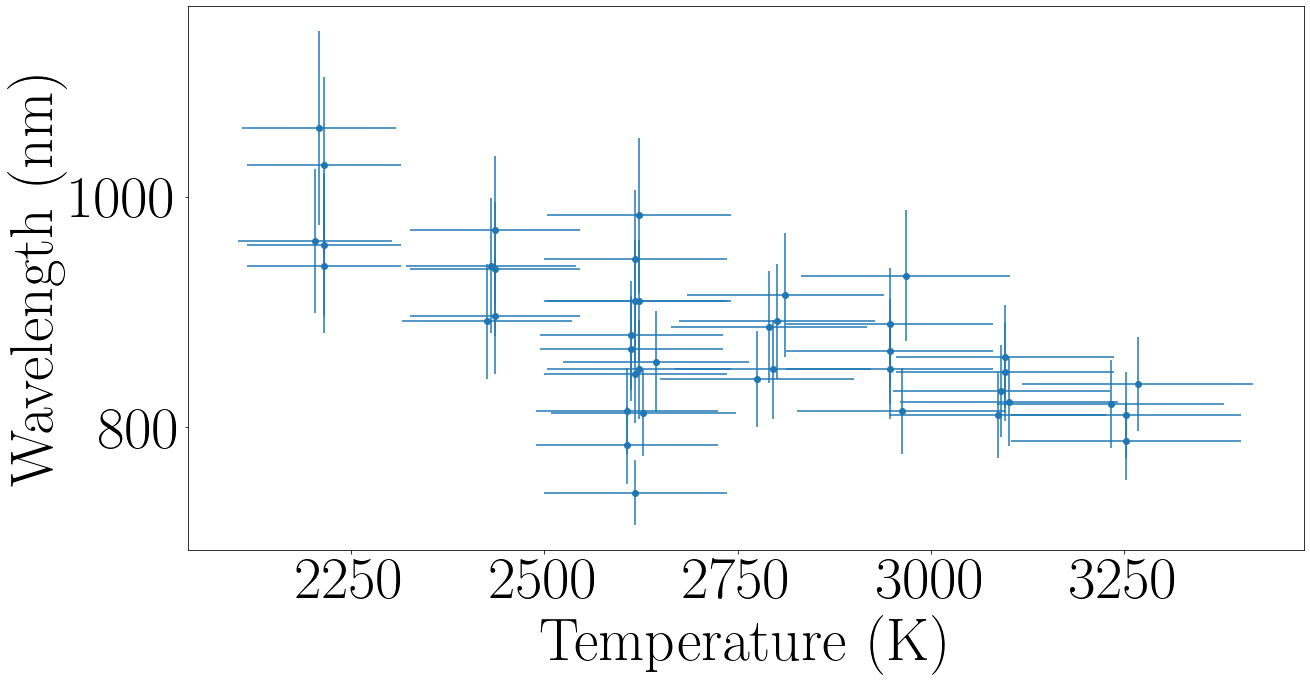

In [270]:
plt.figure(figsize=(20,10))
plt.errorbar([i.nominal_value for i in temperature_list], [i.nominal_value for i in wavelength_list], yerr=[i.std_dev for i in wavelength_list], xerr=[i.std_dev for i in temperature_list], fmt="o")
plt.xlabel("Temperature (K)")
plt.ylabel("Wavelength (nm)")